In [167]:
from pathlib import Path
import numpy as np, rasterio, cv2
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point, mapping
import rasterio
from rasterio.transform import xy
from rasterio.plot import plotting_extent
from deepforest import main as df_main
import folium
import matplotlib.pyplot as plt
from rasterio.transform import xy
from rasterio.features import geometry_mask


OUT = Path("outputs")
RASTER_PATH = OUT / "naip_aoi.tif"  # from notebook 01
GPKG_LINES = OUT / "roads_aoi.gpkg"  # from notebook 01 (layers: lines, lines_buffer)

RASTER_PATH, GPKG_LINES

(PosixPath('outputs/naip_aoi.tif'), PosixPath('outputs/roads_aoi.gpkg'))

In [225]:
UPSCALE = 3.0  # multiplies the image size before inference, higher- better recall, slower to train. lower - faster, but we may miss small crowns
PATCH = 1000  # sliding window size, high better context, smaller faster but may mss the edge
OVERLAP = 0.20  # overlap between tiles
CONF = 0.35  # confidence score
IOU = 0.50  # lower its more agressive on merging, higher can lead to duplicates
NDVI_MIN = 0.5
AREA_M2 = (10, 80)  # drop tiny shrubs & huge blobs
ASPECT = (
    0.4,
    2.5,
)  # shape filter, marrow - stricter, wider, may keep odd shapes, for trees the ideal is: 0,4 -2.5

m = df_main.deepforest()
m.use_release()

with rasterio.open(RASTER_PATH) as src:
    transform, crs = src.transform, src.crs
    resx, resy = src.res
    # read RGB only (R,G,B) and NIR/RED for NDVI
    rgb = np.moveaxis(src.read([1, 2, 3]), 0, 2)  # (H,W,3)
    red = src.read(1).astype(np.float32)
    nir = src.read(4).astype(np.float32)

# ensure uint8 for DeepForest
if rgb.dtype != np.uint8:
    lo, hi = float(rgb.min()), float(rgb.max())
    rgb = ((rgb - lo) / max(hi - lo, 1e-6) * 255).astype(np.uint8)

# upscale for inference
h, w = rgb.shape[:2]
rgb_up = (
    cv2.resize(rgb, (int(w * UPSCALE), int(h * UPSCALE)), interpolation=cv2.INTER_CUBIC)
    if UPSCALE != 1.0
    else rgb
)

# tiled prediction on array (avoids 4-band issue)
preds = m.predict_tile(
    image=rgb_up,
    patch_size=PATCH,
    patch_overlap=OVERLAP,
    iou_threshold=IOU,
    return_plot=False,
)

# conf + downscale boxes back if we upscaled
if len(preds):
    if "score" in preds:
        preds = preds[preds.score >= CONF].copy()
    if UPSCALE != 1.0:
        for c in ["xmin", "xmax", "ymin", "ymax"]:
            preds[c] = preds[c] / UPSCALE
    preds.reset_index(drop=True, inplace=True)
else:
    import pandas as pd

    preds = pd.DataFrame(columns=["xmin", "ymin", "xmax", "ymax", "score"])


# boxes -> geopolys
def boxes_to_polys(df):
    polys = []
    for r in df.itertuples():
        corners_rc = [
            (r.ymin, r.xmin),
            (r.ymin, r.xmax),
            (r.ymax, r.xmax),
            (r.ymax, r.xmin),
        ]
        corners_xy = [xy(transform, rr, cc, offset="center") for rr, cc in corners_rc]
        polys.append(Polygon(corners_xy))
    return gpd.GeoDataFrame(df.copy(), geometry=polys, crs=crs)


crowns = boxes_to_polys(preds)

# size/shape filters in physical units
pix_area_m2 = abs(resx * resy)

wpx = (preds.xmax - preds.xmin).astype(float)  # Series
hpx = (preds.ymax - preds.ymin).astype(float)  # Series

area_m2 = (wpx * hpx) * pix_area_m2  # Series

# aspect ratio ≥ 1 using Series ops (avoid np.where)
hpx_safe = hpx.replace(0, np.nan)
ar = (wpx / hpx_safe).astype(float)
ar = ar.where(ar >= 1, 1 / ar)  # still a Series

keep = (area_m2.between(*AREA_M2) & ar.between(*ASPECT)).fillna(False)

crowns = crowns.loc[keep].reset_index(drop=True)

# NDVI gate
ndvi = (nir - red) / (nir + red + 1e-6)


def poly_mean(arr, geom):
    mask = geometry_mask(
        [mapping(geom)], transform=transform, out_shape=arr.shape, invert=True
    )
    vals = arr[mask]
    return float(np.nanmean(vals)) if vals.size else np.nan


if len(crowns):
    crowns["mean_ndvi"] = [poly_mean(ndvi, g) for g in crowns.geometry]
    crowns = crowns[crowns.mean_ndvi >= NDVI_MIN].reset_index(drop=True)

print("final crowns:", len(crowns))

Reading config file: /Users/anapaola/Documents/Repos/wildfire_powerlines/.venv/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /Users/anapaola/Documents/Repos/wildfire_powerlines/.venv/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 196/196 [00:41<00:00,  4.73it/s]
10419 predictions in overlapping windows, applying non-max supression
7897 predictions kept after non-max suppression


final crowns: 1


In [226]:
def bbox_to_poly(b, transform):
    """b = (xmin, ymin, xmax, ymax) in pixel coords (x=col, y=row)."""
    xmin, ymin, xmax, ymax = map(float, b)
    corners_rc = [(ymin, xmin), (ymin, xmax), (ymax, xmax), (ymax, xmin)]
    corners_xy = [xy(transform, r, c, offset="center") for (r, c) in corners_rc]
    return Polygon(corners_xy)


if len(preds):
    geoms = [
        bbox_to_poly((r.xmin, r.ymin, r.xmax, r.ymax), transform)
        for r in preds.itertuples()
    ]
    crowns = gpd.GeoDataFrame(preds.copy(), geometry=geoms, crs=crs)
else:
    crowns = gpd.GeoDataFrame(preds.copy(), geometry=[], crs=crs)

# (optional) filter by confidence
# CONF = 0.2
# crowns = crowns[crowns["score"] >= CONF].reset_index(drop=True)
print("crowns after threshold:", len(crowns))

crowns after threshold: 3455


In [227]:
# If you saved both layers in Notebook 01:
lines = gpd.read_file(GPKG_LINES, layer="lines").to_crs(crs)
try:
    lines_buf = gpd.read_file(GPKG_LINES, layer="lines_buffer").to_crs(crs)
except Exception:
    # fallback: buffer here if gpkg has only 'lines'
    lines_buf = lines.copy()
    lines_buf["geometry"] = lines_buf.geometry.buffer(15)  # meters

print("lines:", len(lines), "| buffers:", len(lines_buf))

# Intersections: crowns within buffer
if len(crowns) and len(lines_buf):
    crowns_near = gpd.sjoin(
        crowns, lines_buf[["geometry"]], predicate="intersects", how="inner"
    )
    crowns_near = crowns_near.drop(
        columns=[c for c in crowns_near.columns if c.startswith("index_")],
        errors="ignore",
    )
else:
    crowns_near = crowns.iloc[0:0].copy()

print("crowns near lines:", len(crowns_near))

# Distance to nearest line (for ranking)
if len(crowns):
    centroids = crowns.copy()
    centroids["geometry"] = centroids.geometry.centroid
    nearest = gpd.sjoin_nearest(
        centroids, lines[["geometry"]], how="left", distance_col="dist_to_line"
    )
    crowns["dist_to_line"] = nearest["dist_to_line"].values
    crowns_near = crowns[
        crowns.index.isin(crowns_near.index)
    ]  # add distances to near set

lines: 8 | buffers: 8
crowns near lines: 0


In [228]:
# Save all crowns and near-line subset
gpkg_out = OUT / "crowns.gpkg"
crowns.to_file(gpkg_out, layer="crowns_all", driver="GPKG")
crowns_near.to_file(gpkg_out, layer="crowns_near_lines", driver="GPKG")

csv_out = OUT / "crowns_near_lines.csv"
cols = ["xmin", "ymin", "xmax", "ymax", "score", "dist_to_line"]
(
    crowns_near[cols + ["geometry"]]
    .assign(wkt=crowns_near.geometry.to_wkt())
    .drop(columns=["geometry"])
    .to_csv(csv_out, index=False)
)

print("Wrote:", gpkg_out, "and", csv_out)

Wrote: outputs/crowns.gpkg and outputs/crowns_near_lines.csv


In [229]:
# Project to WGS84 for web map
lines_wgs = lines.to_crs(4326)
near_wgs = crowns_near.to_crs(4326)

# map center = raster center (approx)
with rasterio.open(RASTER_PATH) as src:
    cx, cy = (
        (src.bounds.left + src.bounds.right) / 2,
        (src.bounds.bottom + src.bounds.top) / 2,
    )
    # CRS->WGS84
    import pyproj

    T = pyproj.Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
    clon, clat = T.transform(cx, cy)

m = folium.Map(location=[clat, clon], zoom_start=14, control_scale=True)

# Add lines
folium.GeoJson(
    lines_wgs.__geo_interface__,
    name="Roads",
    style_function=lambda x: {"color": "red", "weight": 2, "opacity": 0.8},
).add_to(m)


# Add near-line crowns (as polygons)
def style_fn(_):
    return {"color": "#2ecc71", "weight": 1, "fill": True, "fillOpacity": 0.3}


folium.GeoJson(
    near_wgs.__geo_interface__, name="Crowns near roads", style_function=style_fn
).add_to(m)

folium.LayerControl().add_to(m)
html_map = OUT / "crowns_near_roads.html"
m.save(html_map)
html_map

PosixPath('outputs/crowns_near_roads.html')

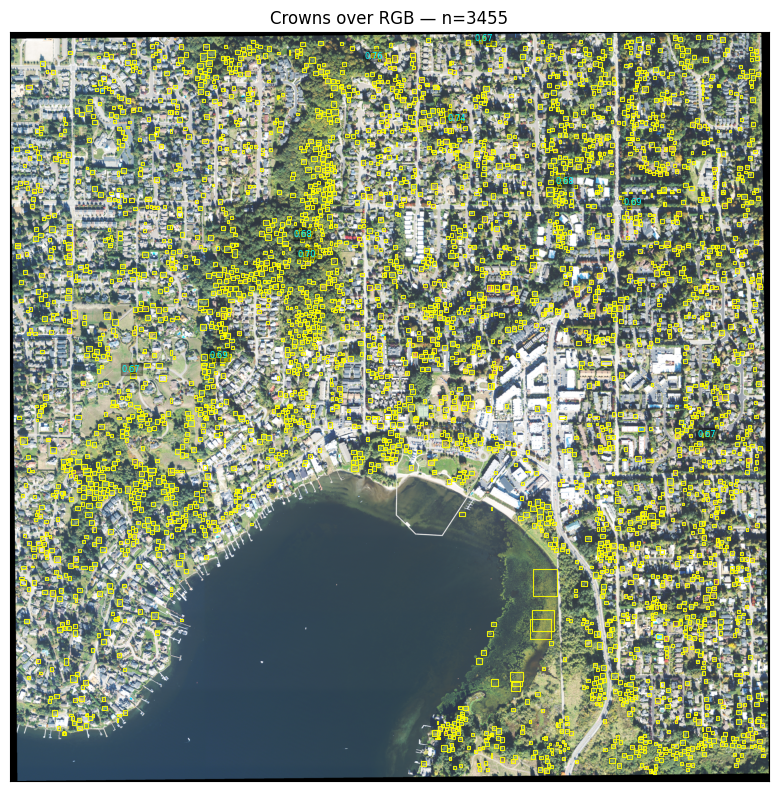

Saved: outputs/overlay_crowns_rgb.png


In [230]:
# --- Overlay crowns on RGB (geospatial) and save PNG ---


overlay_png = OUT / "overlay_crowns_rgb.png"

with rasterio.open(RASTER_PATH) as src:
    img = src.read([1, 2, 3])  # (3, H, W)
    rgb = np.moveaxis(img, 0, -1)  # (H, W, 3)
    extent = plotting_extent(src)  # (xmin, xmax, ymin, ymax)


# light percent stretch for nicer contrast
def stretch_uint8(a, p=(2, 98)):
    a = a.astype(np.float32)
    out = np.zeros_like(a, dtype=np.uint8)
    for i in range(3):
        lo, hi = np.percentile(a[..., i], p)
        if hi <= lo:
            lo, hi = float(a[..., i].min()), float(a[..., i].max())
        x = (a[..., i] - lo) / (hi - lo)
        out[..., i] = np.clip(x, 0, 1) * 255
    return out


rgb8 = stretch_uint8(rgb)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb8, extent=extent)
if len(crowns):
    # polygon outlines
    crowns.boundary.plot(ax=ax, linewidth=0.8, edgecolor="yellow", alpha=0.9)
    # optional: label first few boxes with score
    for i, r in enumerate(crowns.head(10).itertuples()):
        cx, cy = r.geometry.centroid.x, r.geometry.centroid.y
        ax.text(
            cx,
            cy,
            f"{r.score:.2f}",
            color="cyan",
            fontsize=6,
            ha="center",
            va="center",
            bbox=dict(facecolor="black", alpha=0.3, pad=1),
        )
else:
    ax.text(
        0.02,
        0.98,
        "No crowns",
        transform=ax.transAxes,
        va="top",
        ha="left",
        color="white",
        bbox=dict(facecolor="black", alpha=0.4, pad=3),
    )
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"Crowns over RGB — n={len(crowns)}")
plt.tight_layout()
plt.savefig(overlay_png, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", overlay_png)

In [233]:
summary = {
    "total_crowns": int(len(crowns)),
    "near_line_crowns": int(len(crowns_near)),
    "pct_near": float(100.0 * len(crowns_near) / max(len(crowns), 1)),
    "threshold": CONF,
}
summary

{'total_crowns': 3455,
 'near_line_crowns': 0,
 'pct_near': 0.0,
 'threshold': 0.35}

In [234]:
print("image size (H, W):", rgb.shape[:2])  # from nb02
print(preds.head()[["xmin", "ymin", "xmax", "ymax", "score"]])

wpx = (preds.xmax - preds.xmin).median()
hpx = (preds.ymax - preds.ymin).median()
print("median box size (px):", float(wpx), float(hpx))

image size (H, W): (3743, 3789)
          xmin         ymin         xmax         ymax     score
0  1804.666667   107.333333  1826.000000   129.000000  0.761645
1  2219.666667   416.000000  2243.333333   439.666667  0.739817
2  1472.666667  1097.666667  1490.333333  1115.666667  0.696981
3  3101.000000   842.666667  3119.000000   860.000000  0.692363
4  1029.333333  1605.000000  1050.666667  1625.666667  0.689983
median box size (px): 17.333333333333314 17.66666666666667
